# Étude de marché 🐔

Objectifs :
- Exporter les produits dans de nouveaux produits plutôt que de produire sur place
- Étudier les régimes alimentaires de tous les pays, notamment en termes de protéines d'origine animale et en termes de calories
- Cibler plus particulièrement certains pays, dans le but d'approfondir ensuite l'étude de marché (produire des "groupes" de pays, plus ou moins gros, dont on connaît les caractéristiques)
- Identifier les pays propices à une insertion dans le marché du poulet

In [367]:
pip install pca

Note: you may need to restart the kernel to use updated packages.


In [368]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import normalize # Normalisation
from sklearn.preprocessing import StandardScaler
from pca import pca # ACP
import scipy.cluster.hierarchy as shc # Dendrogramme
from sklearn.cluster import AgglomerativeClustering # Récupération des clusters
import scipy.stats as stats # Tests statistiques
from scipy.special import boxcox1p
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [369]:
# Couleurs
black = '#000'
red = '#d50000'
teal = '#00bfa5'
indigo = '#304ffe'
amber = '#ffab00'
purple = '#aa00ff'
palette = [red, teal, indigo, amber, purple, black]

# Exploration

## 4 jeux de données

- Sources (FAO) : 
    - [New Food Balances](http://www.fao.org/faostat/en/#data/FBS)
    - [Annual population](http://www.fao.org/faostat/en/#data/OA)
- Variables :
    - L'ensemble des pays disponibles
    - La différence de population entre une année antérieure et l'année courante
    - Disponibilité alimentaire en protéines par habitant
    - Disponibilité alimentaire en calories par habitant
    - Proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire 

In [370]:
# URL sources
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p5/sources/fao_'

# Colonnes inutiles
drop_columns = ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Flag', 'Flag Description', 'Year Code']

# Dataframes
food = pd.read_csv(url + 'new-food-balances.csv').drop(drop_columns, axis=1) # Nouveaux Bilans Alimentaires
livestock = pd.read_csv(url + 'livestock-primary.csv').drop(drop_columns, axis=1) # Élevage primaire
population = pd.read_csv(url + 'annual-population.csv').drop(drop_columns + ['Note'], axis=1) # Séries temporelles annuelles
security = pd.read_csv(url + 'security-indicators.csv').drop(drop_columns + ['Note'], axis=1) # Données de la sécurité alimentaire

In [371]:
food.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
665,New Food Balances,Uzbekistan,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,93.27
548,New Food Balances,Saudi Arabia,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,3307.00
456,New Food Balances,Nicaragua,Food supply (kcal/capita/day),Grand Total,2018,kcal/capita/day,2582.00
489,New Food Balances,Paraguay,Protein supply quantity (g/capita/day),Grand Total,2018,g/capita/day,69.40
486,New Food Balances,Panama,Food supply (kcal/capita/day),Animal Products,2018,kcal/capita/day,619.00


In [372]:
livestock.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
49,Livestock Primary,Belarus,Export Quantity,"Meat, chicken",2018,tonnes,163779
152,Livestock Primary,Djibouti,Import Quantity,"Meat, chicken",2018,tonnes,3111
5,Livestock Primary,Albania,Protein supply quantity (g/capita/day),"Meat, chicken",2018,g/capita/day,3
162,Livestock Primary,Egypt,Production,"Meat, chicken",2018,tonnes,1324327
280,Livestock Primary,Kyrgyzstan,Import Quantity,"Meat, chicken",2018,tonnes,26528


In [373]:
population.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
238,Annual population,Liberia,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,3607.860
22,Annual population,Australia,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,21332.282
341,Annual population,Qatar,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,2781.682
20,Annual population,Aruba,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,101.358
173,Annual population,Greenland,Total Population - Both sexes,Population - Est. & Proj.,2018,1000 persons,56.564


In [374]:
security.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
527,Suite of Food Security Indicators,Panama,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,20640.8
289,Suite of Food Security Indicators,Guinea,Value,"Gross domestic product per capita, PPP, dissem...",2018,I$,2498.4
756,Suite of Food Security Indicators,Zambia,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,2747.4
578,Suite of Food Security Indicators,Russian Federation,Value,Political stability and absence of violence/te...,2018,index,-0.5
443,Suite of Food Security Indicators,Mexico,Value,"Gross domestic product per capita, PPP, dissem...",2008,I$,18424.3


## Jointures et pivot

In [375]:
# Concaténation des 4 dataframes
data = pd.concat([food, livestock, population, security])
data.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
34,Suite of Food Security Indicators,Australia,Value,Political stability and absence of violence/te...,2008,index,0.960
51,Annual population,Bosnia and Herzegovina,Total Population - Both sexes,Population - Est. & Proj.,2008,1000 persons,3754.271
52,Livestock Primary,Belgium,Export Quantity,"Meat, chicken",2018,tonnes,531847.000
493,Suite of Food Security Indicators,Nicaragua,Value,Political stability and absence of violence/te...,2008,index,-0.220
581,Suite of Food Security Indicators,Rwanda,Value,Political stability and absence of violence/te...,2008,index,-0.320


In [376]:
# Table pivot
data = data.pivot_table(index='Area', values='Value', columns=['Element', 'Item', 'Year']).reset_index()
data

Element                       Area Export Quantity  \
Item                                 Meat, chicken   
Year                                          2018   
0                      Afghanistan           154.0   
1                          Albania             NaN   
2                          Algeria             NaN   
3                   American Samoa             NaN   
4                          Andorra             NaN   
..                             ...             ...   
233      Wallis and Futuna Islands             NaN   
234                 Western Sahara             NaN   
235                          Yemen             NaN   
236                         Zambia          1387.0   
237                       Zimbabwe             NaN   

Element Food supply (kcal/capita/day)             Import Quantity  \
Item                  Animal Products Grand Total   Meat, chicken   
Year                             2018        2018            2018   
0                               191.0      2040.0         23913.0   
1                              1003.0      3360.0         11588.0   
2                               390.0      3322.0            27.0   
3                                 NaN         NaN             NaN   
4                                 NaN         NaN             NaN   
..                                ...         ...             ...   
233                               NaN         NaN             NaN   
234                               NaN         NaN             NaN   
235                             142.0      2154.0         95992.0   
236                             159.0      2002.0         10540.0   
237                             159.0      1908.0          3758.0   

Element    Production Protein supply quantity (g/capita/day)              \
Item    Meat, chicken                        Animal Products Grand Total   
Year             2018                                   2018        2018   
0             28850.0                                  10.79       55.52   
1             15587.0                                  61.75      115.74   
2            278279.0                                  24.73       91.83   
3                 NaN                                    NaN         NaN   
4                 NaN                                    NaN         NaN   
..                ...                                    ...         ...   
233               NaN                                    NaN         NaN   
234               NaN                                    NaN         NaN   
235          179768.0                                  10.38       54.52   
236           49487.0                                  13.70       60.53   
237           65837.0                                  11.59       44.15   

Element               Total Population - Both sexes             \
Item    Meat, chicken     Population - Est. & Proj.              
Year             2018                          2008       2018   
0                 NaN                     27722.276  37171.921   
1                 3.0                      3002.678   2882.740   
2                 2.0                     34730.608  42228.408   
3                 NaN                        57.492     55.465   
4                 NaN                        83.862     77.006   
..                ...                           ...        ...   
233               NaN                        13.578     11.661   
234               NaN                       468.633    567.402   
235               NaN                     21892.146  28498.683   
236               NaN                     12848.530  17351.708   
237               2.0                     12379.549  14438.802   

Element                                                                                 Value  \
Item    Gross domestic product per capita, PPP, dissemination (constant 2011 international $)   
Year                                                                                     200

In [377]:
# Abbréviations du multiIndex
export, imports, production, chicken, kcal, prot = 'Export Quantity', 'Import Quantity', 'Production', 'Meat, chicken', 'Food supply (kcal/capita/day)', 'Protein supply quantity (g/capita/day)'
pop = 'Total Population - Both sexes'
pop2 = 'Population - Est. & Proj.'
animal = 'Animal Products'
total = 'Grand Total'
secu = 'Value'
pib = 'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)'
stable = 'Political stability and absence of violence/terrorism (index)'

# Années analysées
annee_a = 2008
annee_b = 2018

# Nouvelles variables
df = pd.DataFrame()
df['Pays'] = data['Area']
df['Dispo_calories'] = data[kcal][total][annee_b]
df['Dispo_protéines'] = data[prot][total][annee_b]
df['Ratio protéines animales'] = data[prot][animal][annee_b] / data[prot][total][annee_b]
df['Millions habitants'] = data[pop][pop2][annee_b] / 1000
df['Croissance population'] = data[pop][pop2][annee_b] / data[pop][pop2][annee_a]
df['PIB'] = data[secu][pib][annee_b]
df['Croissance PIB'] = data[secu][pib][annee_b] / data[secu][pib][annee_a]
df['Poulet imports / exports'] = data[imports][chicken][annee_b] / data[export][chicken][annee_b]

# Suppression des valeurs manquantes et infinies : restent 106 pays
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index()
df = df.drop(['index'], axis=1)
df

# --> 106 pays au total (sans valeurs manquantes)

,Pays,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports
0,Afghanistan,2040.0,55.52,0.194344,37.171921,1.340868,2190.2,1.379393,155.279221
1,Antigua and Barbuda,2445.0,80.19,0.645218,0.096286,1.127510,21115.8,0.914029,849.142857
2,Argentina,3307.0,106.77,0.646717,44.361150,1.106811,22745.9,0.984513,0.040777
3,Armenia,2997.0,94.35,0.480551,2.951745,1.015176,12715.0,1.214712,435.297297
4,Australia,3391.0,105.94,0.667359,24.898152,1.167158,49576.0,1.096894,0.145991
...,...,...,...,...,...,...,...,...,...
101,United Kingdom of Great Britain and Northern I...,3344.0,103.92,0.557737,67.141684,1.080402,46309.8,1.056045,1.279315
102,United Republic of Tanzania,2373.0,58.93,0.206007,56.313438,1.345475,2590.0,1.363517,43.307692
103,United States of America,3782.0,113.74,0.646035,327.096265,1.077797,61544.4,1.111030,0.019352
104,Uruguay,3202.0,86.50,0.534335,3.449285,1.032652,21590.8,1.362041,0.442524


# ACP et hiérarchisation

## Corrélations
Fortes corrélations entre :
- la dispo. en protéines et la dispo. en calories
- la dispo. en protéines et le ratio de protéines animales
- la dispo. en protéines et le PIB

Nous sommes intéressés par les pays les plus susceptibles de consommer du poulet, donc ceux ayant un fort ratio de protéines animales. Les corrélations montrent que ces pays sont susceptibles d'avoir un fort PIB, et de grandes disponibilités en protéines et calories.

In [378]:
# Projection sur les variables quantitatives
df_acp = df.drop(['Pays'], axis=1)
df_acp.sample()

,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports
40,2835.0,76.77,0.40693,4.002942,0.966275,14257.1,1.523422,5.839129


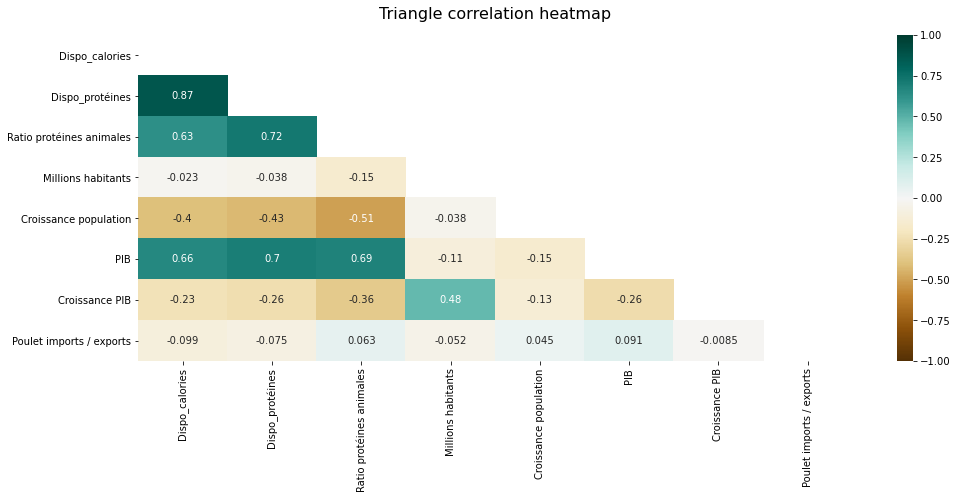

In [379]:
# Triangle de corrélations
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(
    df_acp.corr(), 
    mask=np.triu(np.ones_like(df_acp.corr(), dtype=np.bool)), 
    vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

colinearites = []

## Standardisation des variables

Centrer = normaliser

In [380]:
# Variables à normaliser et standardiser
variables_non_std = df_acp.drop(['Ratio protéines animales', 'Croissance population', 'Croissance PIB'], axis=1)
variables_non_std.sample()

,Dispo_calories,Dispo_protéines,Millions habitants,PIB,Poulet imports / exports
97,3711.0,110.68,82.340088,28298.9,0.012889


In [381]:
# Avec StandardScaler

# Centrage et réduction 
X = variables_non_std.values
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Réunion de toutes les variables standardisées
df_acp_standardscaler = pd.merge(
  df_acp.drop(variables_non_std.columns, axis=1), # Variables n'ayant pas nécessité une standardisation
  pd.DataFrame(X_scaled, columns=variables_non_std.columns), # Variables précédemment standardisées
  left_index=True, right_index=True)
df_acp_standardscaler

,Ratio protéines animales,Croissance population,Croissance PIB,Dispo_calories,Dispo_protéines,Millions habitants,PIB,Poulet imports / exports
0,0.194344,1.340868,1.379393,-2.302662,-1.661394,-0.117018,-1.044608,-0.146424
1,0.645218,1.127510,0.914029,-1.342782,-0.370873,-0.309529,-0.224905,0.162107
2,0.646717,1.106811,0.984513,0.700223,1.019564,-0.079689,-0.154302,-0.215451
3,0.480551,1.015176,1.214712,-0.034500,0.369856,-0.294702,-0.588759,-0.021912
4,0.667359,1.167158,1.096894,0.899309,0.976145,-0.180748,1.007760,-0.215405
...,...,...,...,...,...,...,...,...
101,0.557737,1.080402,1.056045,0.787916,0.870476,0.038596,0.866295,-0.214901
102,0.206007,1.345475,1.363517,-1.513427,-1.483013,-0.017628,-1.027292,-0.196212
103,0.646035,1.077797,1.111030,1.826009,1.384174,1.388378,1.526134,-0.215461
104,0.534335,1.032652,1.362041,0.451365,-0.040788,-0.292119,-0.204331,-0.215273


In [382]:
# Avec normalize()

# Centrage et réduction 
X = variables_non_std.values
X_scaled = normalize(X)

# Réunion de toutes les variables standardisées
df_acp = pd.merge(
  df_acp.drop(variables_non_std.columns, axis=1), # Variables n'ayant pas nécessité une standardisation
  pd.DataFrame(X_scaled, columns=variables_non_std.columns), # Variables précédemment standardisées
  left_index=True, right_index=True)
df_acp

,Ratio protéines animales,Croissance population,Croissance PIB,Dispo_calories,Dispo_protéines,Millions habitants,PIB,Poulet imports / exports
0,0.194344,1.340868,1.379393,0.680486,0.018520,0.012399,0.730588,5.179673e-02
1,0.645218,1.127510,0.914029,0.114929,0.003769,0.000005,0.992564,3.991461e-02
2,0.646717,1.106811,0.984513,0.143874,0.004645,0.001930,0.989583,1.774061e-06
3,0.480551,1.015176,1.214712,0.229286,0.007218,0.000226,0.972762,3.330247e-02
4,0.667359,1.167158,1.096894,0.068240,0.002132,0.000501,0.997667,2.937929e-06
...,...,...,...,...,...,...,...,...
101,0.557737,1.080402,1.056045,0.072022,0.002238,0.001446,0.997400,2.755330e-05
102,0.206007,1.345475,1.363517,0.675311,0.016770,0.016026,0.737065,1.232455e-02
103,0.646035,1.077797,1.111030,0.061335,0.001845,0.005305,0.998101,3.138371e-07
104,0.534335,1.032652,1.362041,0.146698,0.003963,0.000158,0.989173,2.027403e-05


## Sur 2 composantes

### Sur les variables normalisées avec StandardScaler()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


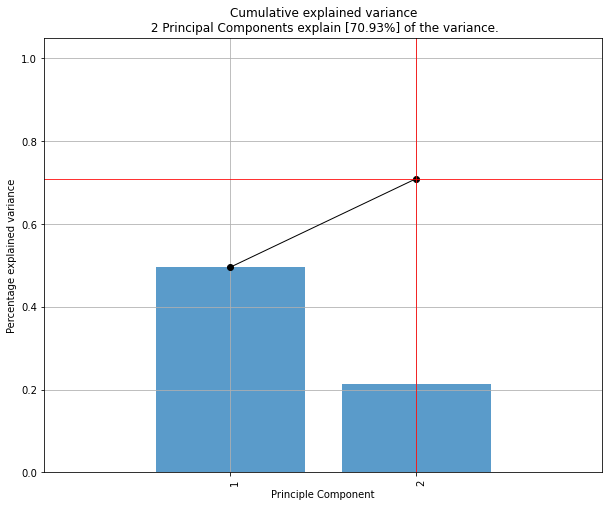

<Figure size 432x288 with 0 Axes>

In [383]:
model = pca(n_components=2)
results = model.fit_transform(df_acp_standardscaler)
fig, ax = model.plot()
plt.show()

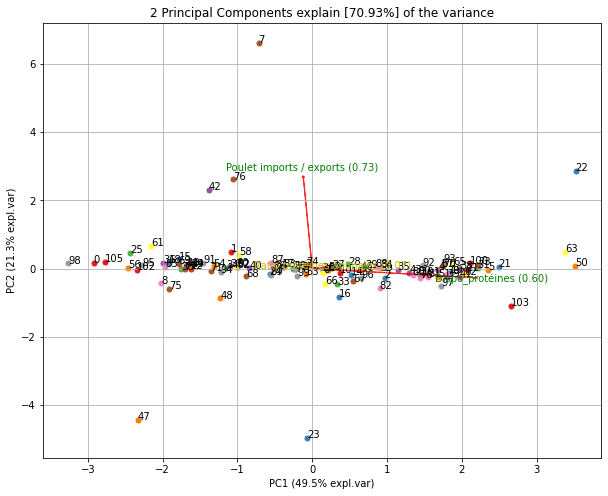

In [384]:
fig, ax = model.biplot(n_feat=3, legend=None)

### Sur les variables normalisées avec normalize()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


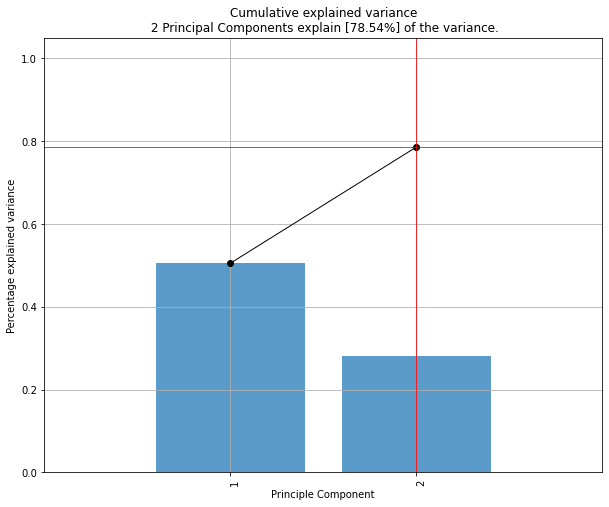

<Figure size 432x288 with 0 Axes>

In [385]:
model = pca(n_components=2)
results = model.fit_transform(df_acp)
fig, ax = model.plot()
plt.show()

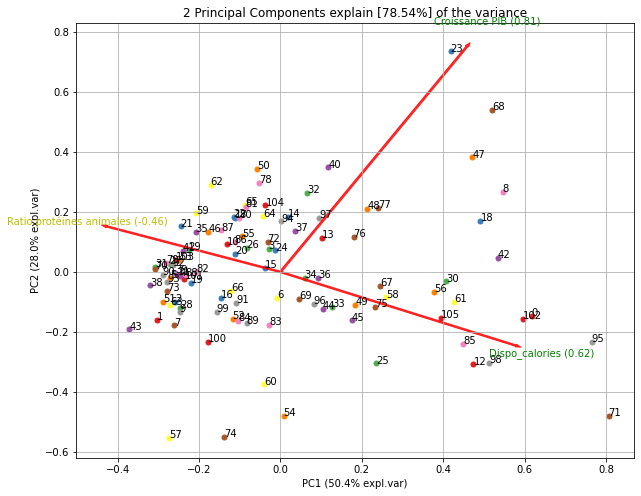

In [386]:
fig, ax = model.biplot(n_feat=3, legend=None)

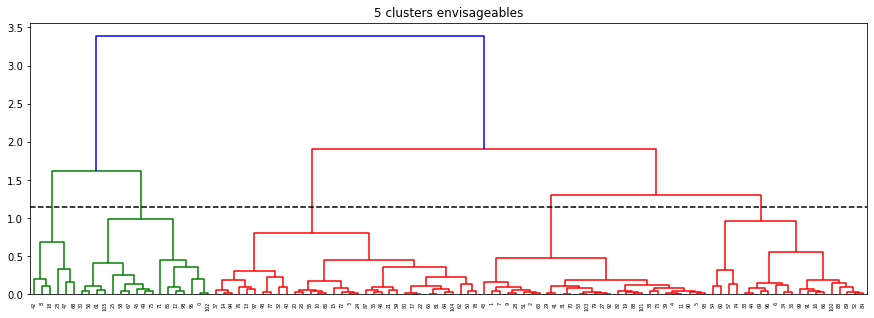

In [387]:
# Dendrogramme sur les 2 composantes de l'ACP
plt.figure(figsize=(15, 5))  
shc.dendrogram(shc.linkage(results['PC'], method='ward'))
plt.axhline(y=1.15, color='black', linestyle='dashed') # Threshold
plt.title('5 clusters envisageables')  
plt.show()

In [388]:
# Cluster pour chaque individu
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['Cluster'])
deux_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)
deux_composantes = pd.merge(deux_composantes, df['Pays'], left_index=True, right_index=True)
deux_composantes

,PC1,PC2,Cluster,Pays
0,0.617305,-0.146168,0,Afghanistan
1,-0.302696,-0.159371,4,Antigua and Barbuda
2,-0.258638,-0.099505,4,Argentina
3,-0.029182,0.077231,2,Armenia
4,-0.247755,-0.012540,4,Australia
...,...,...,...,...
101,-0.235929,-0.023455,4,United Kingdom of Great Britain and Northern I...
102,0.596131,-0.156027,0,United Republic of Tanzania
103,-0.256723,0.039760,4,United States of America
104,-0.036716,0.222007,2,Uruguay


In [389]:
# Moyenne par cluster de chaque composante issue de l'ACP (centroïdes)
centroides = deux_composantes.groupby(['Cluster']).mean().reset_index()
centroides['Cluster'] = 'Centroïde'
centroides['Pays'] = 'Centroïde'
centroides

,Cluster,PC1,PC2,Pays
0,Centroïde,0.421138,-0.179079,Centroïde
1,Centroïde,-0.049334,-0.190187,Centroïde
2,Centroïde,-0.041619,0.168588,Centroïde
3,Centroïde,0.497095,0.357112,Centroïde
4,Centroïde,-0.266903,-0.035400,Centroïde


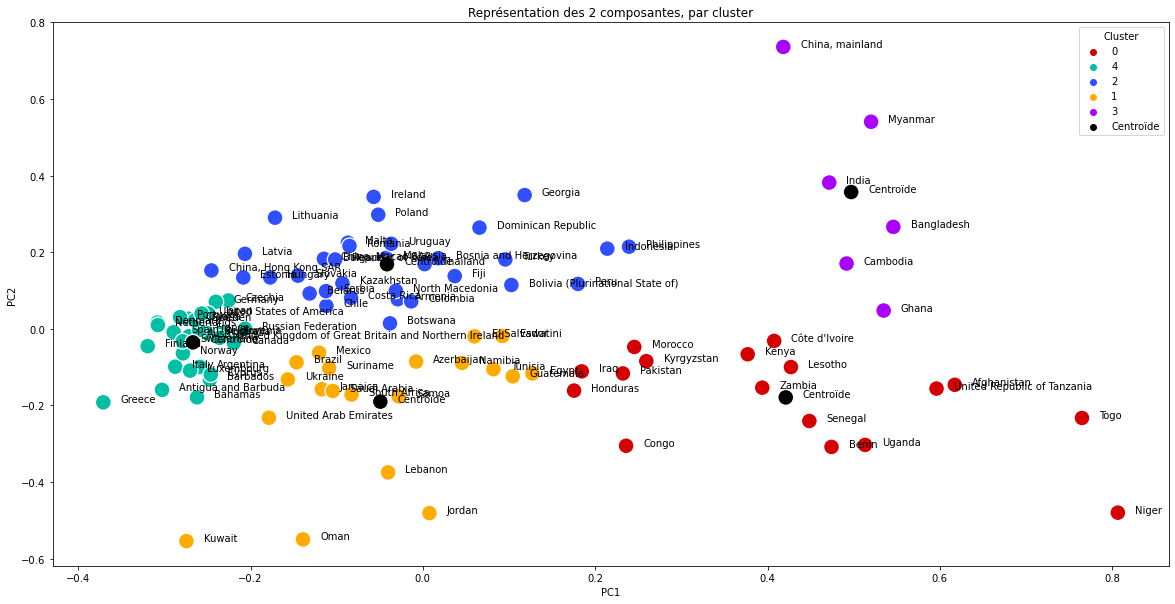

In [390]:
# Jointure des centroïdes sur la dataframe des 2 composantes
deux_composantes_centroides = pd.concat([deux_composantes, centroides])

# Scatterplot des 2 composantes
plt.figure(figsize=(20,10))
ax = sns.scatterplot(data=deux_composantes_centroides, x='PC1', y='PC2', hue='Cluster', palette=palette, s=250)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(deux_composantes_centroides['PC1'], deux_composantes_centroides['PC2'], deux_composantes_centroides['Pays'], plt.gca())
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

## Sur 3 composantes

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


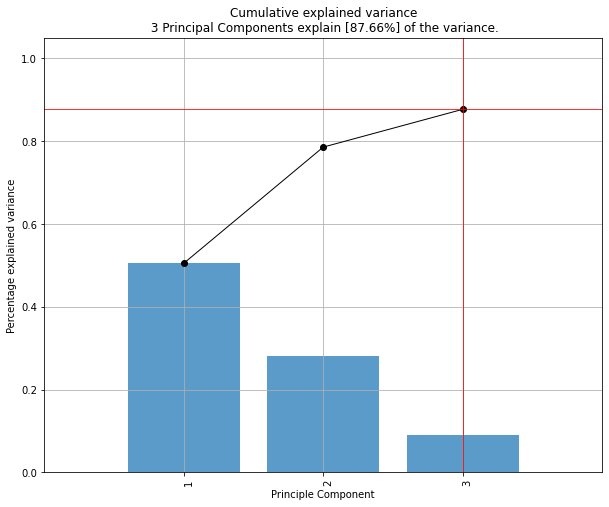

<Figure size 432x288 with 0 Axes>

In [391]:
model = pca(n_components=3)
results = model.fit_transform(df_acp)
fig, ax = model.plot()
plt.show()

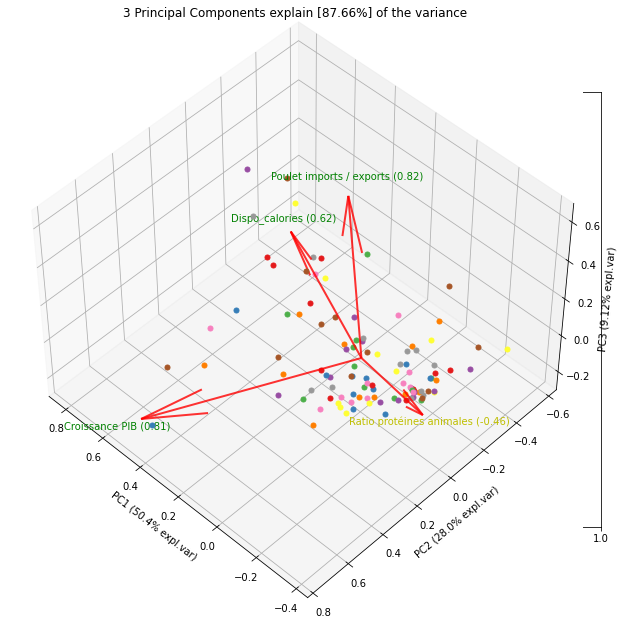

In [392]:
fig, ax = model.biplot3d(n_feat=4, legend=None)
plt.show()

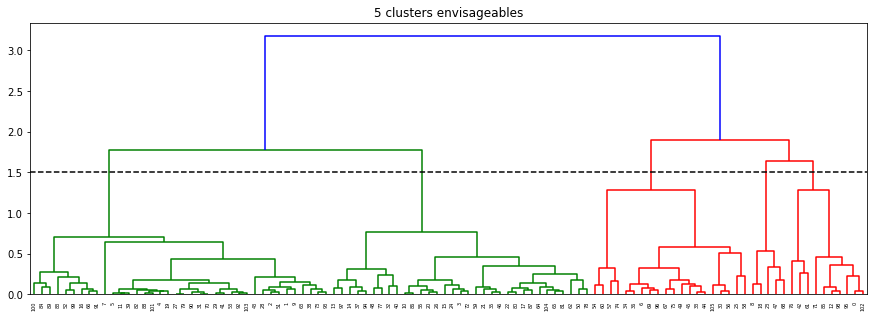

In [393]:
# Dendrogramme sur les 3 composantes de l'ACP
plt.figure(figsize=(15, 5))  
shc.dendrogram(shc.linkage(results['PC'], method='ward'))
plt.axhline(y=1.5, color='black', linestyle='dashed') # Threshold
plt.title('5 clusters envisageables')  
plt.show()

In [394]:
# Cluster pour chaque individu
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['Cluster'])
trois_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)
trois_composantes

,PC1,PC2,PC3,Cluster
0,0.617305,-0.146168,-0.022836,0
1,-0.302696,-0.159371,0.052158,3
2,-0.258638,-0.099505,0.020773,3
3,-0.029182,0.077231,0.037208,1
4,-0.247755,-0.012540,-0.025152,3
...,...,...,...,...
101,-0.235929,-0.023455,-0.001944,3
102,0.596131,-0.156027,-0.055672,0
103,-0.256723,0.039760,0.003511,3
104,-0.036716,0.222007,-0.022723,1


In [395]:
# Moyenne par cluster de chaque composante issue de l'ACP
centroides = trois_composantes.groupby(['Cluster']).mean().reset_index()
centroides['Cluster'] = 'Centroïde'
centroides

,Cluster,PC1,PC2,PC3
0,Centroïde,0.536291,-0.180192,0.134014
1,Centroïde,-0.048336,0.170147,-0.020235
2,Centroïde,0.128406,-0.179833,-0.062296
3,Centroïde,-0.231151,-0.060822,0.025263
4,Centroïde,0.489556,0.418994,-0.077291


In [396]:
# Jointure des centroïdes sur la dataframe des 2 composantes
trois_composantes_centroides = pd.concat([trois_composantes, centroides])

# Visualisation des centroïdes
fig = px.scatter_3d(
    pd.concat([trois_composantes_centroides, centroides]), 
    x='PC1', y='PC2', z='PC3', color='Cluster', symbol='Cluster', opacity=.75)
fig.update(layout_coloraxis_showscale=False)
fig.show()

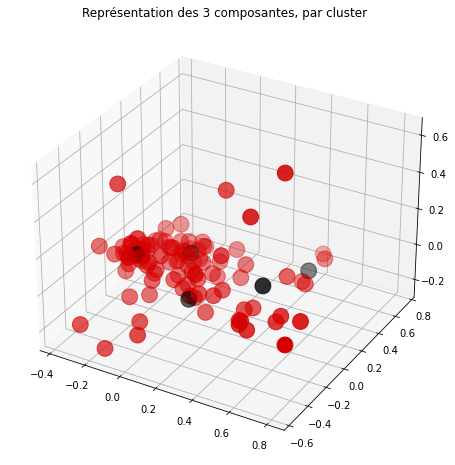

In [397]:
# Jointure des centroïdes sur la dataframe des 2 composantes
centroides['Cluster'] = '99' # matplot n'autorise que des valeurs numériques dans 'c='
trois_composantes_centroides = pd.concat([trois_composantes, centroides])

# Représentation avec mplot3d
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
    trois_composantes_centroides['PC1'].values, 
    trois_composantes_centroides['PC2'].values, 
    trois_composantes_centroides['PC3'].values, 
    c=trois_composantes_centroides['Cluster'], s=250, 
    cmap=ListedColormap(palette)
    )
plt.title('Représentation des 3 composantes, par cluster')
plt.show()

# Analyse des clusters

## Résumé

In [398]:
# Jointure des données non normalisées avec les clusters
df = pd.merge(df, clusters, left_index=True, right_index=True)
df.sample(3)

,Pays,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports,Cluster
89,South Africa,2899.0,84.37,0.427048,57.792518,1.160971,12630.8,1.000206,10.818739,3
60,Lebanon,2857.0,69.15,0.324946,6.859408,1.439618,15612.0,0.916724,2.381658,2
61,Lesotho,2323.0,66.70,0.288906,2.108328,1.060992,2748.5,1.239627,1691.900000,0


In [399]:
# Nombre et exemples de pays dans chaque cluster
for i in df.sort_values('Cluster')['Cluster'].unique():
    print(
        'Cluster', i, ':', 
        len(df[df['Cluster']==i]), 'pays (' + 
        ", ".join(df[df['Cluster']==i].sample(5)['Pays'].values), '...)')

Cluster 0 : 10 pays (Benin, Afghanistan, Lesotho, Senegal, United Republic of Tanzania ...)
Cluster 1 : 33 pays (Uruguay, Colombia, Philippines, Turkey, Botswana ...)
Cluster 2 : 20 pays (El Salvador, Iraq, Congo, Eswatini, Kyrgyzstan ...)
Cluster 3 : 38 pays (Portugal, Spain, Brazil, Canada, Cyprus ...)
Cluster 4 : 5 pays (Cambodia, China, mainland, Bangladesh, Myanmar, India ...)


In [400]:
# Moyenne des variables non standardisées, par cluster
df.groupby(['Cluster']).mean()

,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports
Cluster,,,,,,,,
0,2484.000000,63.490000,0.228773,25.775037,1.294432,3685.220000,1.294943,1768.215423
1,3104.484848,90.268788,0.514565,26.019313,1.050999,29035.551515,1.312225,273.406621
2,2760.150000,75.579000,0.332889,28.731171,1.283389,11314.590000,1.122278,140.566380
3,3244.184211,98.550263,0.571830,42.801738,1.079433,40316.086842,1.021339,557.456153
4,2691.000000,76.278000,0.316439,602.324977,1.109140,7073.980000,1.794603,133.146437


## Box plots par variable

**Cluster 0**
- Le plus faible en disponibilité protéique, en ratio de protéines animales et en PIB
- De loin de le plus fort ratio d'import / export de poulet, expliquée par le faible ratio de protéines animales de ces pays

**Cluster 1**
- Les deuxièmes plus forts ratios de protéines animales, disponibilités protéique et calorique, PIB et croissance du PIB
- Les plus faibles populations, croissances de la population et ratios d'import / export de poulet

**Cluster 2**
- Ne dispose que de la plus forte croissance de population
- Toutes les autres variables sont dans la moyenne des autres clusters

**Cluster 3**
- Les plus forts ratios de protéine animale, PIB, disponibilités protéique et calorique 
- Le deuxième plus grand nombre d'habitants
- La plus faible croissance du PIB (s'explique par le haut PIB)

**Cluster 4**
- De loin les plus grands nombres d'habitants
- Le deuxième plus faible PIB
- De loin la plus forte croissance du PIB
- Le deuxième plus fort ratio d'import / export de poulet, loin devant les trois suivants

On cherche des pays à fort ratio de protéines d'origine animales, lui-même positivement corrélé au PIB et aux dispobilités en protéines et calories. Les clusters 3 et 1 apparaissent comme les plus intéressants. 

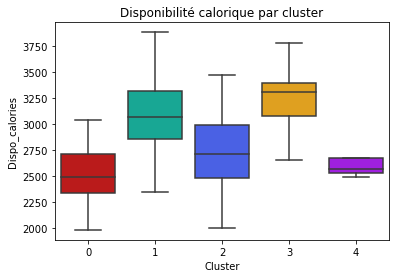

In [401]:
sns.boxplot(data=df, y='Dispo_calories', x='Cluster', showfliers=False, palette=palette)
plt.title('Disponibilité calorique par cluster')
plt.show()

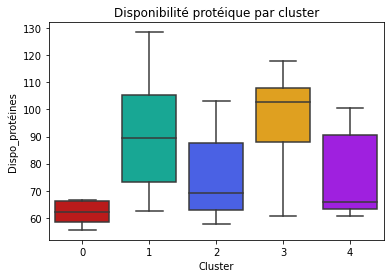

In [402]:
sns.boxplot(data=df, y='Dispo_protéines', x='Cluster', showfliers=False, palette=palette)
plt.title('Disponibilité protéique par cluster')
plt.show()

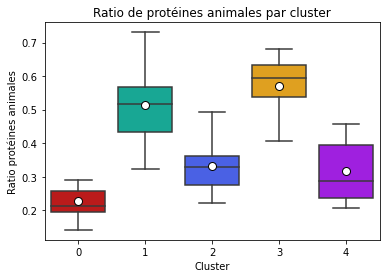

In [403]:
sns.boxplot(
    data=df, y='Ratio protéines animales', x='Cluster', palette=palette, showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Ratio de protéines animales par cluster')
plt.show()

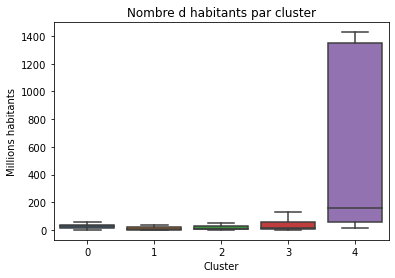

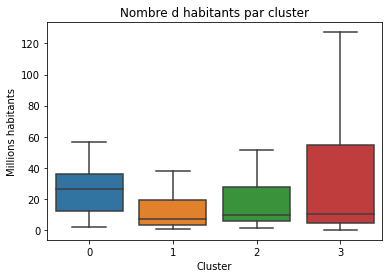

In [404]:
sns.boxplot(data=df, y='Millions habitants', x='Cluster', showfliers=False)
plt.title('Nombre d habitants par cluster')
plt.show()

sns.boxplot(data=df.drop(df[df['Cluster']==4].index), y='Millions habitants', x='Cluster', showfliers=False)
plt.title('Nombre d habitants par cluster')
plt.show()

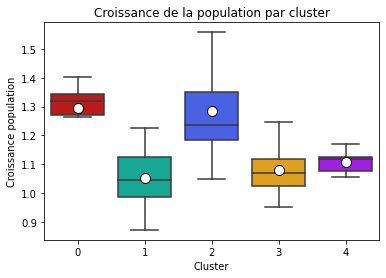

In [405]:
sns.boxplot(
    data=df, y='Croissance population', x='Cluster', palette=palette, showfliers=False,
    showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'10'})
plt.title('Croissance de la population par cluster')
plt.show()

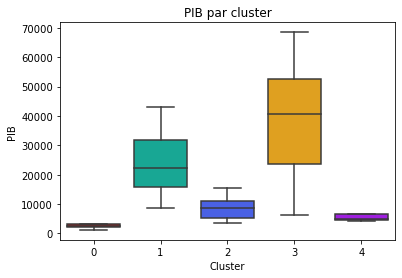

In [406]:
sns.boxplot(data=df, y='PIB', x='Cluster', showfliers=False, palette=palette)
plt.title('PIB par cluster')
plt.show()

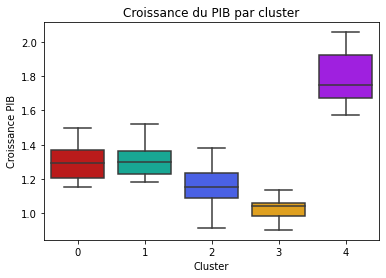

In [407]:
sns.boxplot(data=df, y='Croissance PIB', x='Cluster', showfliers=False, palette=palette)
plt.title('Croissance du PIB par cluster')
plt.show()

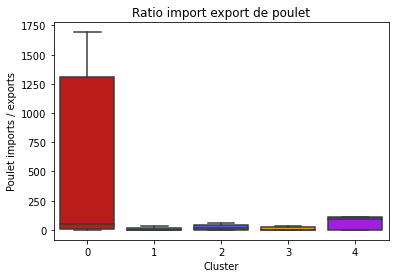

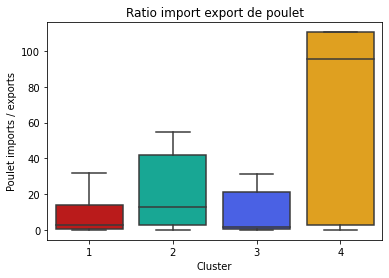

In [408]:
sns.boxplot(data=df, y='Poulet imports / exports', x='Cluster', showfliers=False, palette=palette)
plt.title('Ratio import export de poulet')
plt.show()

sns.boxplot(data=df.drop(df[df['Cluster']==0].index), y='Poulet imports / exports', x='Cluster', showfliers=False, palette=palette)
plt.title('Ratio import export de poulet')
plt.show()

# Analyse du cluster 3

In [409]:
import geopandas as gpd
import geoplot

In [410]:
# Dataset naturalearth_lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.rename(columns={'name': 'Pays'}, inplace=True)
world.sort_values(by='Pays').head(10)

,pop_est,continent,Pays,iso_a3,gdp_md_est,geometry
103,34124811,Asia,Afghanistan,AFG,64080.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
125,3047987,Europe,Albania,ALB,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948..."
74,29310273,Africa,Angola,AGO,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
159,4050,Antarctica,Antarctica,ATA,810.0,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
109,3045191,Asia,Armenia,ARM,26300.0,"POLYGON ((46.50572 38.77061, 46.14362 38.74120..."
137,23232413,Oceania,Australia,AUS,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."
114,8754413,Europe,Austria,AUT,416600.0,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."
145,9961396,Asia,Azerbaijan,AZE,167900.0,"MULTIPOLYGON (((46.40495 41.86068, 46.68607 41..."


In [411]:
# Dataframe ne contenant que le cluster choisi
pays = df[df['Cluster'].isin([3])]
pays.sort_values(by='Pays')

,Pays,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports,Cluster
1,Antigua and Barbuda,2445.0,80.19,0.645218,0.096286,1.127510,21115.8,0.914029,849.142857,3
2,Argentina,3307.0,106.77,0.646717,44.361150,1.106811,22745.9,0.984513,0.040777,3
4,Australia,3391.0,105.94,0.667359,24.898152,1.167158,49576.0,1.096894,0.145991,3
5,Austria,3695.0,109.12,0.603281,8.891388,1.065918,55687.2,1.041688,1.090448,3
7,Bahamas,2655.0,80.69,0.649399,0.385637,1.122078,35500.5,0.902964,19536.000000,3
9,Barbados,2956.0,88.69,0.575262,0.286641,1.023915,15674.9,0.924953,14.460317,3
11,Belgium,3769.0,99.87,0.586563,11.482178,1.065260,51246.0,1.057445,0.392179,3
16,Brazil,3301.0,95.68,0.561977,209.469323,1.090814,14596.2,1.034436,0.000888,3
19,Canada,3566.0,104.12,0.545044,37.074562,1.112093,48924.4,1.061469,1.568819,3
27,Croatia,3074.0,90.60,0.614790,4.156405,0.954917,27557.5,1.045901,2.045084,3


In [412]:
# Harmonisation des noms de pays entre les 2 dataframes
world = world.replace('Russia', 'Russian Federation')
world = world.replace('United Kingdom', 'United Kingdom of Great Britain and Northern Ireland')
world = world.replace('Dominican Rep.', 'Dominican Republic')
world = world.replace('Bolivia', 'Bolivia (Plurinational State of)')
world = world.replace('Bosnia and Herz.', 'Bosnia and Herzegovina')
world = world.replace('South Korea', 'Republic of Korea')
world = world.replace('Macedonia', 'North Macedonia')

In [413]:
# Pays non représentables sur la carte
pays[~pays['Pays'].isin(world['Pays'])]

,Pays,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports,Cluster
1,Antigua and Barbuda,2445.0,80.19,0.645218,0.096286,1.127510,21115.8,0.914029,849.142857,3
9,Barbados,2956.0,88.69,0.575262,0.286641,1.023915,15674.9,0.924953,14.460317,3
83,Samoa,3030.0,87.85,0.592715,0.196129,1.070205,6329.4,0.990904,416.000000,3


In [414]:
# Jointure entre pays et world
pays = world.merge(pays, on='Pays')
pays

,pop_est,continent,Pays,iso_a3,gdp_md_est,geometry,Dispo_calories,Dispo_protéines,Ratio protéines animales,Millions habitants,Croissance population,PIB,Croissance PIB,Poulet imports / exports,Cluster
0,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.840 49.000, -122.974 49.0...",3566.0,104.12,0.545044,37.074562,1.112093,48924.4,1.061469,1.568819,3
1,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.840 49.000, -120.000 49.0...",3782.0,113.74,0.646035,327.096265,1.077797,61544.4,1.111030,0.019352,3
2,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1...",3307.0,106.77,0.646717,44.361150,1.106811,22745.9,0.984513,0.040777,3
3,142257519,Europe,Russian Federation,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...",3345.0,101.40,0.548225,145.734038,1.017349,26667.7,1.068238,1.207824,3
4,329988,North America,Bahamas,BHS,9066.0,"MULTIPOLYGON (((-78.980 26.790, -78.510 26.870...",2655.0,80.69,0.649399,0.385637,1.122078,35500.5,0.902964,19536.000000,3
5,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.143 79.674, 15.523 80.016, ...",3371.0,113.43,0.598695,5.337962,1.118831,63332.8,1.013836,23.913043,3
6,54841552,Africa,South Africa,ZAF,739100.0,"POLYGON ((16.345 -28.577, 16.824 -28.082, 17.2...",2899.0,84.37,0.427048,57.792518,1.160971,12630.8,1.000206,10.818739,3
7,124574795,North America,Mexico,MEX,2307000.0,"POLYGON ((-117.128 32.535, -115.991 32.612, -1...",3157.0,91.50,0.489399,126.190788,1.138749,19992.2,1.085100,98.666176,3
8,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.374 -33.768, -53.651 -33.202, -5...",3301.0,95.68,0.561977,209.469323,1.090814,14596.2,1.034436,0.000888,3
9,591919,South America,Suriname,SUR,8547.0,"POLYGON ((-54.525 2.312, -55.098 2.524, -55.57...",2698.0,60.73,0.406883,0.575990,1.113836,16609.4,1.039283,26.148633,3


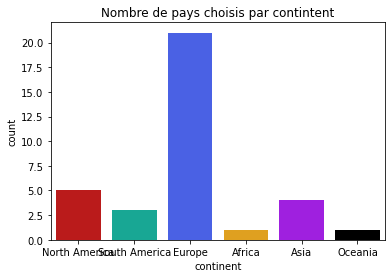

In [415]:
# Nombre de pays par continent
sns.countplot(data=pays, x='continent', palette=palette)
plt.title('Nombre de pays choisis par contintent')
plt.show()

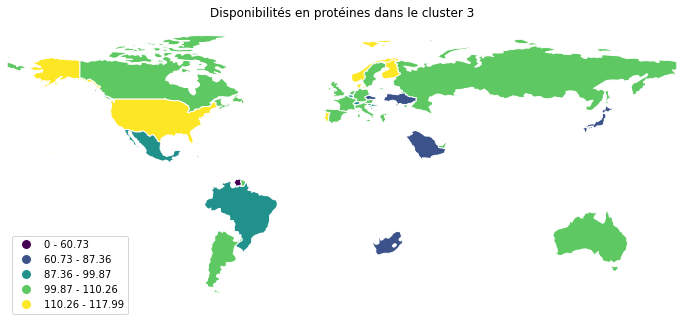

In [416]:
geoplot.choropleth(
    pays, hue='Dispo_protéines',
    edgecolor='white', linewidth=1,
    cmap='viridis', legend=True,
    scheme='FisherJenks', 
    figsize=(12, 15)
)
plt.title('Disponibilités en protéines dans le cluster 3')
plt.show()

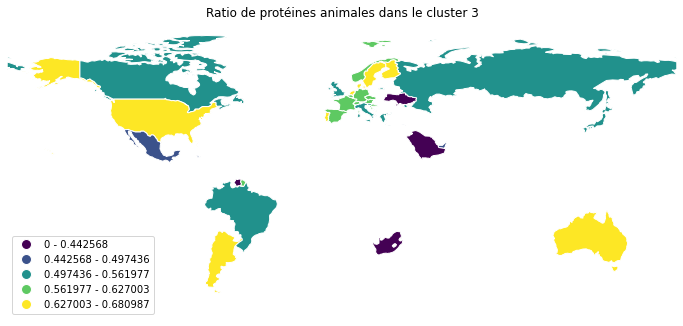

In [417]:
geoplot.choropleth(
    pays, hue='Ratio protéines animales',
    edgecolor='white', linewidth=1,
    cmap='viridis', legend=True,
    scheme='FisherJenks', 
    figsize=(12, 15)
)
plt.title('Ratio de protéines animales dans le cluster 3')
plt.show()

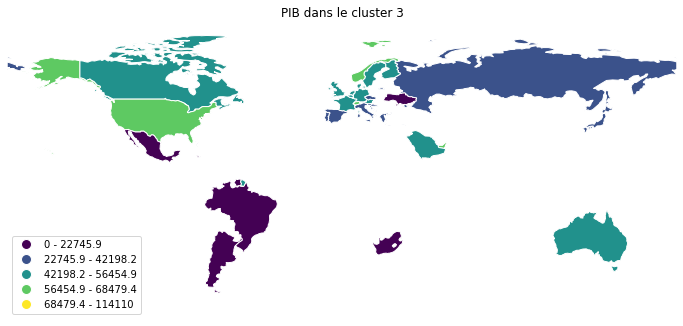

In [418]:
geoplot.choropleth(
    pays, hue='PIB',
    edgecolor='white', linewidth=1,
    cmap='viridis', legend=True,
    scheme='FisherJenks', 
    figsize=(12, 15)
)
plt.title('PIB dans le cluster 3')
plt.show()

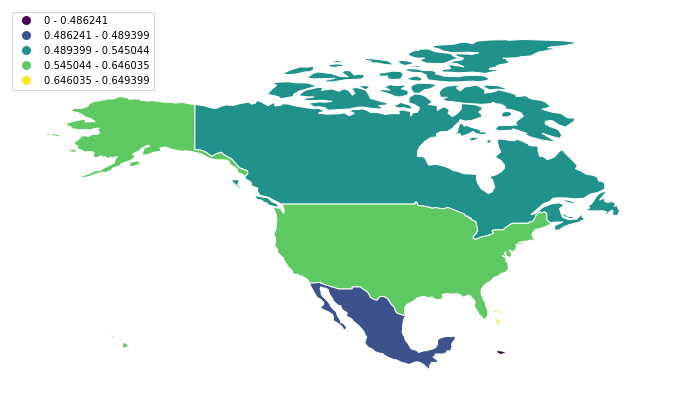

In [419]:
geoplot.choropleth(
    pays[pays['continent']=='North America'], hue='Ratio protéines animales',
    edgecolor='white', linewidth=1,
    cmap='viridis', legend=True,
    scheme='FisherJenks', 
    figsize=(12, 15)
)
plt.show()

# Tests

Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

- un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;
- un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.

## Régressions linéaires
Les corrélations sont positives dans chaque cluster. La corrélation avec le ratio de protéines animales est la plus positive.

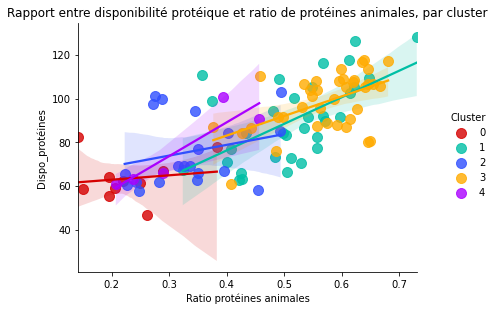

In [420]:
# Entre dispo. en protéines et ratio de protéines animales
sns.lmplot(
    data=df, x='Ratio protéines animales', y='Dispo_protéines', hue='Cluster', 
    palette=palette,
    scatter_kws={"s": 100}, height=4, aspect=4/3)
plt.title('Rapport entre disponibilité protéique et ratio de protéines animales, par cluster')
plt.show()

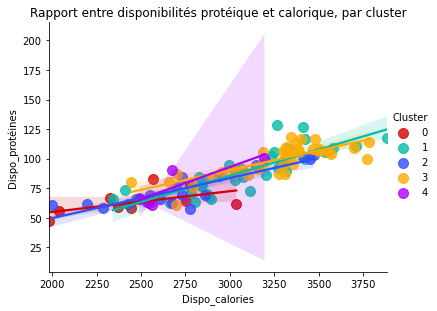

In [421]:
# Entre dispo. en protéines et dispo. en calories
sns.lmplot(
    data=df, x='Dispo_calories', y='Dispo_protéines', hue='Cluster', 
    palette=palette,
    scatter_kws={"s": 100}, height=4, aspect=4/3)
plt.title('Rapport entre disponibilités protéique et calorique, par cluster')
plt.show()

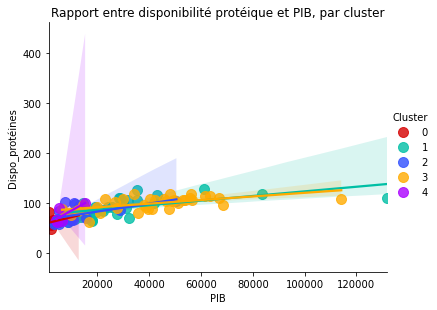

In [422]:
# Entre dispo. en protéines et PIB
sns.lmplot(
    data=df, x='PIB', y='Dispo_protéines', hue='Cluster', 
    palette=palette,
    scatter_kws={"s": 100}, height=4, aspect=4/3)
plt.title('Rapport entre disponibilité protéique et PIB, par cluster')
plt.show()

## Normalité

Cluster 0
Test de Shapiro (stat = 0.941, p-value = 0.56943160295486450195312500000000000)
H0 acceptée : distribution probablement normale


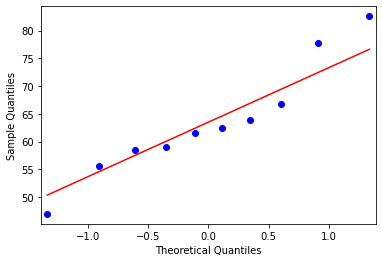

Cluster 3
Test de Shapiro (stat = 0.943, p-value = 0.05351651832461357116699218750000000)
H0 acceptée : distribution probablement normale


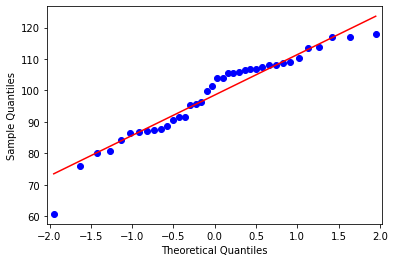

Cluster 1
Test de Shapiro (stat = 0.959, p-value = 0.24854178726673126220703125000000000)
H0 acceptée : distribution probablement normale


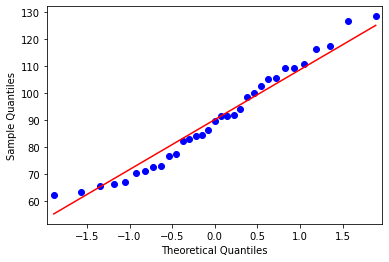

Cluster 2
Test de Shapiro (stat = 0.858, p-value = 0.00734777469187974929809570312500000)
H0 rejetée : distribution probablement pas normale


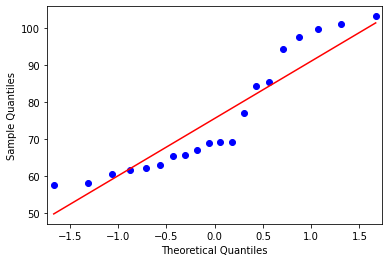

Cluster 4
Test de Shapiro (stat = 0.834, p-value = 0.14848925173282623291015625000000000)
H0 acceptée : distribution probablement normale


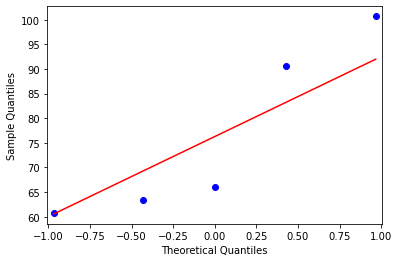

In [423]:
variable = 'Dispo_protéines' # Variable étudiée

# Test de Shapiro
def test_shapiro(variable):
    stat, p = stats.shapiro(boxcox1p(variable, 1))
    print('Test de Shapiro (stat = %.3f, p-value = %.35f)' % (stat, p))
    if p>.05:
        print('H0 acceptée : distribution probablement normale')
    else:
        print('H0 rejetée : distribution probablement pas normale')
    qqplot(variable, line='s')
    plt.show()

# Test de Shapiro pour chaque cluster
for i in df['Cluster'].unique():
  print('Cluster', i)
  test_shapiro(df[df['Cluster']==i][variable])

## ANOVA

In [424]:
# Test d'ANOVA entre catégorielle et quantitative
model = smf.ols('Dispo_protéines ~ Cluster', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('Test d\'ANOVA\n',
      'comparaison des moyennes de k populations, à partir d\'échantillons aléatoires',
      'et indépendants prélevés dans chacune d\'elles')
#print('Moyennes des modalités :')
#print(sample.groupby('Cluster').mean()['Dispo_calories'])
print('\np-value :', p, '\nstat :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.')
    
print(    '\nConditions :'
    '\n- les populations étudiées suivent une distribution normale',
    '\n- les variances des populations sont toutes égales (homoscédasticité)')

Test d'ANOVA
 comparaison des moyennes de k populations, à partir d'échantillons aléatoires et indépendants prélevés dans chacune d'elles

p-value : 0.0012695386314423502 
stat : 10.977491945827724
H1: one or more of the means of the samples are unequal.

Conditions :
- les populations étudiées suivent une distribution normale 
- les variances des populations sont toutes égales (homoscédasticité)


## Homoscédasticité

In [425]:
# Nombre de samples, basé sur le nombre d'invididus dans le plus petit cluster
samples = min([len(df[df['Cluster']==3]), len(df[df['Cluster']==1])])

# Valeurs de chaque cluster
a = df[df['Cluster']==3][variable].sample(samples).values
b = df[df['Cluster']==1][variable].sample(samples).values

# Test de Levene
stat, p = stats.levene(a, b)
print('Test de Levene : homoscédasticité (des résidus ?)\n',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed')   

Test de Levene : homoscédasticité (des résidus ?)
 
stats : 4.303433993315642 
p-value : 0.04206240182890402
H1: les variances ne sont pas égales (essayer Welch ANOVA)

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed


## Welch

In [426]:
# Test de Welch entre catégorielle et quantitative
df_welch = df[df['Cluster'].isin([1,3])]
stat, p = stats.ttest_ind(df_welch[variable], df_welch['Cluster'])
print('Test de Welch\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.')

Test de Welch

p-value : 2.3123400161417144e-88 
stat : 47.61510836397605
H1: one or more of the means of the samples are unequal.


# Références

**Modules**
- [PCA](https://pypi.org/project/pca/)

**Tests**
- [ANOVA à un facteur - Introduction](http://unt-ori2.crihan.fr/unspf/2010_Limoges_Vignoles_StatsAnova/co/09-1-1-introduction.html)


**ACP**
- [Cours d'ACP : théorie et pratique](https://www.youtube.com/watch?v=8qw0bNfK4H0) (Youtube)
- [A Beginner’s Guide to Hierarchical Clustering and how to Perform it in Python](https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/)